nháp project IQA BIQ2021-kaggle

thực hiện chạy thử với dataset BIQ2021, phiên bản nén 430 MB (bản gốc 40GB)

sau đó chạy mô hình với các dataset SPAQ (17GB) và koniq-10k-dataset (8GB)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr
import torch.optim as optim
from tqdm.auto import tqdm
import timm
import csv
from kagglehub import dataset_download



# Loading data

In [2]:
path = dataset_download("nisarahmedrana/BIQ2021")
print("Path to dataset files:", path)

DATASET_DIR = "/kaggle/input/BIQ2021"


CSV_FILE = os.path.join(DATASET_DIR, "BIQ2021.csv")
IMAGE_PATH = DATASET_DIR

df = pd.read_csv(CSV_FILE)
df['filepath'] = df['Images'].apply(
    lambda path: os.path.join(IMAGE_PATH, os.path.basename(path).strip())
)
MODEL_SAVE_PATH = "best_model_final.pth"
df.head()

Path to dataset files: /kaggle/input/BIQ2021


,Images,MOS,StandardDeviation,filepath
0,Images (1).jpg,0.138205,0.054030,/kaggle/input/BIQ2021/Images (1).jpg
1,Images (2).jpg,0.654088,0.318964,/kaggle/input/BIQ2021/Images (2).jpg
2,Images (3).jpg,0.679017,0.152763,/kaggle/input/BIQ2021/Images (3).jpg
3,Images (4).jpg,0.442209,0.009709,/kaggle/input/BIQ2021/Images (4).jpg
4,Images (5).jpg,0.484388,0.135056,/kaggle/input/BIQ2021/Images (5).jpg


# Just Visualize

           Images       MOS  StandardDeviation  \
0  Images (1).jpg  0.138205           0.054030   
1  Images (2).jpg  0.654088           0.318964   
2  Images (3).jpg  0.679017           0.152763   
3  Images (4).jpg  0.442209           0.009709   
4  Images (5).jpg  0.484388           0.135056   

                               filepath  
0  /kaggle/input/BIQ2021/Images (1).jpg  
1  /kaggle/input/BIQ2021/Images (2).jpg  
2  /kaggle/input/BIQ2021/Images (3).jpg  
3  /kaggle/input/BIQ2021/Images (4).jpg  
4  /kaggle/input/BIQ2021/Images (5).jpg  

 Thống kê mô tả cho điểm MOS
count    12000.000000
mean         0.512602
std          0.168931
min          0.000000
25%          0.403178
50%          0.530583
75%          0.636948
max          0.948321
Name: MOS, dtype: float64


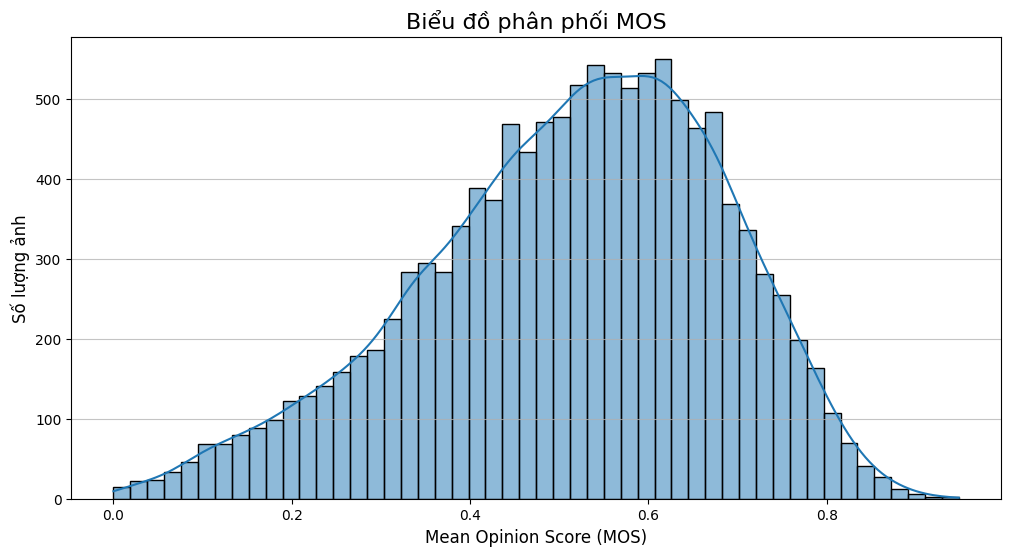

Ảnh mẫu ngẫu nhiên


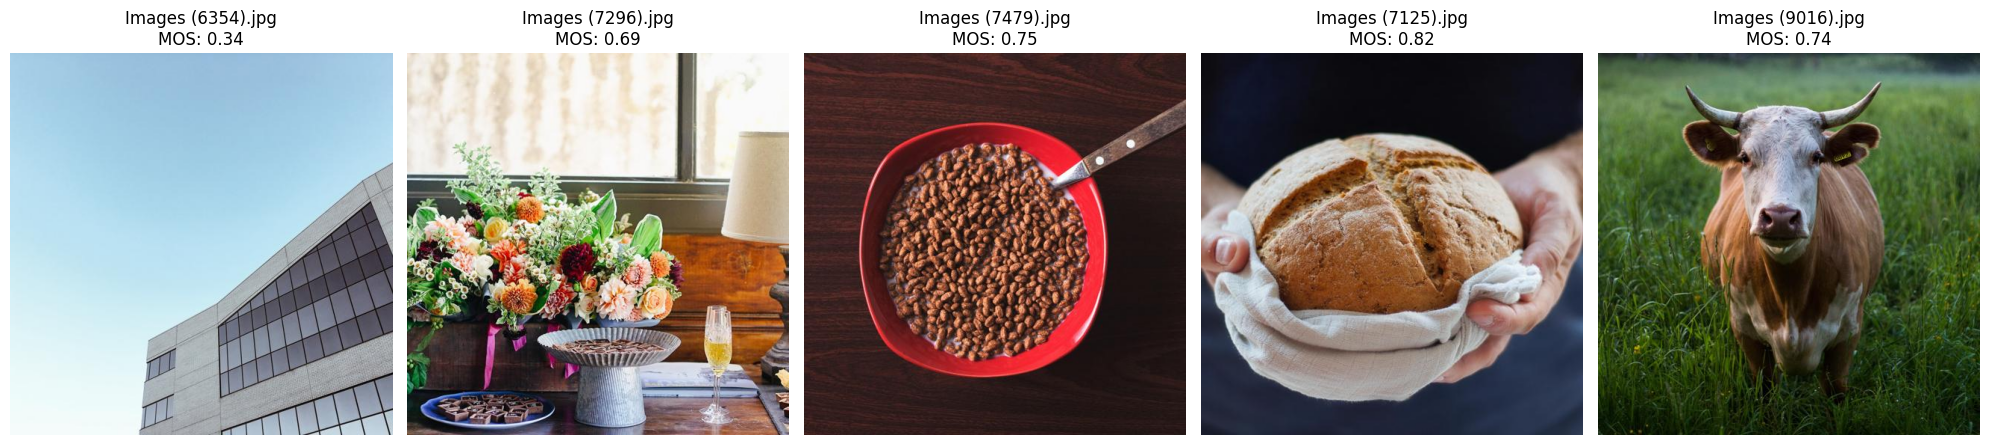

In [3]:

print(df.head())
print("\n Thống kê mô tả cho điểm MOS")
print(df['MOS'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(df['MOS'], bins=50, kde=True)
plt.title('Biểu đồ phân phối MOS', fontsize=16)
plt.xlabel('Mean Opinion Score (MOS)', fontsize=12)
plt.ylabel('Số lượng ảnh', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

print("Ảnh mẫu ngẫu nhiên")
sample_df = df.sample(5)
plt.figure(figsize=(20, 5))
for i, (index, row) in enumerate(sample_df.iterrows()):
    img_file_path = row['filepath']
    ax = plt.subplot(1, 5, i + 1)
    try:
        image = Image.open(img_file_path)
        plt.imshow(image)
        ax.set_title(f"{os.path.basename(img_file_path)}\nMOS: {row['MOS']:.2f}")
        ax.axis('off')
    except FileNotFoundError:
        ax.set_title(f"Không tìm thấy:\n{os.path.basename(img_file_path)}")
        ax.axis('off')
plt.tight_layout()
plt.show()


# Preprocessing data


In [4]:
#hyperparameter
BATCH_SIZE = 16
NUM_WORKERS = 0
NUM_EPOCHS = 20
LEARNING_RATE = 1e-5 

In [5]:
class IQA_Dataset_V2(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        mos_score = self.df.iloc[idx]['MOS']
        std_dev = self.df.iloc[idx]['StandardDeviation']
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        mos_score = torch.tensor([mos_score], dtype=torch.float32)
        std_dev = torch.tensor([std_dev], dtype=torch.float32)
        return image, mos_score, std_dev

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#SSplit train set test set
train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

#instance dataset
train_dataset = IQA_Dataset_V2(train_df, transform=image_transforms)
val_dataset = IQA_Dataset_V2(val_df, transform=image_transforms)
test_dataset = IQA_Dataset_V2(test_df, transform=image_transforms)

#DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print("train_loader, val_loader and test_loader")

train_loader, val_loader and test_loader


In [6]:
#efficientnet_b2 layer
class IQAModel(nn.Module):
    def __init__(self, model_name='efficientnet_b2', pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        
        layer_count = len(list(self.backbone.parameters()))
        for i, param in enumerate(self.backbone.parameters()):
            if i < int(layer_count * 0.8):
                param.requires_grad = False
        
        in_features = self.backbone.get_classifier().in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
    def forward(self, x):
        return self.backbone(x)

In [7]:
# Block 7: Các Hàm Huấn Luyện & Đánh Giá (Nâng Cấp Gradient Accumulation)

def train_one_epoch_v2(model, loader, criterion, optimizer, device, scheduler=None):
    """
    Hàm training đã được nâng cấp để sử dụng Tích Lũy Gradient.
    """
    model.train()
    running_loss = 0.0
    # Reset optimizer ở đầu epoch
    optimizer.zero_grad()
    
    for i, (images, labels, stds) in enumerate(tqdm(loader, desc="Training")):
        images, labels, stds = images.to(device), labels.to(device), stds.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        weights = 1.0 / (stds + 1e-6)
        weights.clamp_(max=10.0)
        
        weighted_loss = (loss * weights).mean()
        
        # <<< LOGIC MỚI 1: CHUẨN HÓA LOSS >>>
        # Chia loss cho số bước tích lũy để lấy trung bình gradient
        weighted_loss = weighted_loss / ACCUMULATION_STEPS
        
        # Tính toán gradient, cộng dồn vào các gradient đã có
        weighted_loss.backward()
        
        # <<< LOGIC MỚI 2: CẬP NHẬT THEO LỊCH >>>
        # Chỉ cập nhật trọng số và scheduler sau ACCUMULATION_STEPS
        if (i + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()
            if scheduler:
                scheduler.step()
            # Reset optimizer để chuẩn bị cho chu kỳ tích lũy tiếp theo
            optimizer.zero_grad()
            
        running_loss += weighted_loss.item() * images.size(0)
        
    # Nhân lại với ACCUMULATION_STEPS để ra con số loss đúng
    return running_loss / len(loader.dataset) * ACCUMULATION_STEPS

def validate_v2(model, loader, device):
    """
    Hàm validate giữ nguyên, không cần tích lũy gradient.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels, _ in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    # Tính toán SROCC và PLCC
    safe_preds = np.nan_to_num(all_preds)
    safe_labels = np.nan_to_num(all_labels)
    
    if len(safe_preds) < 2:
        return 0.0, 0.0 # Không thể tính tương quan nếu có ít hơn 2 mẫu
        
    srocc = spearmanr(safe_preds, safe_labels)[0]
    plcc = pearsonr(safe_preds, safe_labels)[0]
    
    return np.nan_to_num(srocc), np.nan_to_num(plcc)


In [ ]:
# Start training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IQAModel().to(device)
criterion = nn.MSELoss(reduction='none') 

#Sample train with 5 epoch
optimizer = optim.AdamW(model.backbone.classifier.parameters(), lr=1e-4, weight_decay=1e-5)
WARMUP_EPOCHS = 5

for epoch in range(WARMUP_EPOCHS):
    train_loss = train_one_epoch_v2(model, train_loader, criterion, optimizer, device)
    print(f"Warm-up Epoch {epoch + 1}/{WARMUP_EPOCHS} | Train Loss: {train_loss:.4f}")

#Finetuning
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # LEARNING_RATE = 1e-5 từ Block Cấu hình
scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * NUM_EPOCHS, eta_min=1e-7)

best_srocc = -1.0
for epoch in range(NUM_EPOCHS): 
    train_loss = train_one_epoch_v2(model, train_loader, criterion, optimizer, device, scheduler)
    srocc, plcc = validate_v2(model, val_loader, device)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} | LR: {current_lr:.2e} | Train Loss: {train_loss:.4f} | Val SROCC: {srocc:.4f} | Val PLCC: {plcc:.4f}")
    
    if srocc > best_srocc:
        best_srocc = srocc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"New best model saved with SROCC: {best_srocc:.4f}")

print(f"\n--- Done in '{MODEL_SAVE_PATH}' ---")

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

  2025-10-22T07:42:27.020137Z ERROR  Python exception updating progress:, error: PyErr { type: <class 'LookupError'>, value: LookupError(<ContextVar name='shell_parent' at 0x7aeedc441ad0>), traceback: Some(<traceback object at 0x7aed38b24e00>) }, caller: "src/progress_update.rs:313"
    at /home/runner/work/xet-core/xet-core/error_printer/src/lib.rs:28



In [ ]:
print(f"\n Kết quả test '{MODEL_SAVE_PATH}' ---")
final_model = IQAModel().to(device)
final_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

test_srocc, test_plcc = validate_v2(final_model, test_loader, device)

print("\n Test results")
print(f"  Spearman's Rho (SROCC): {test_srocc:.4f}")
print(f"  Pearson's Coeff (PLCC): {test_plcc:.4f}")


**Nhật ký training**
Version5: 

Đánh giá kết quả: Bad model

Kết quả cho ra tệ hơn V4

Train loss rất không ổn định
9.4 -> 19.1 -> 5.9 -> 4.6 -> 3.9 -> 6.6 -> ... -> 19.2 -> 4.0 -> ... -> 12.9

Version 6: Better Model

Hiệu suất mô hình tăng cao, Val SROCC: 0.7108, Val PLCC: 0.7385

Test SROCC = 0.7062 => Mô hình có tính tổng quát hóa tốt, không overfiting

Train Loss giảm đều từ 3 xuống 0.0613 



